In [5]:
import sys
sys.path.append(r'../')
import numpy as np
from scipy import signal
import mat73
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.animation as animation
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
%reload_ext autoreload
%autoreload 2
from functions import *

## Evaluating the microvariable (X) for comparison purposes

In [6]:
X0_tr = np.load('Saved_Y/X0_tr.npy')
X1_tr = np.load('Saved_Y/X1_tr.npy')
X0_tst = np.load('Saved_Y/X0_tst.npy')
X1_tst = np.load('Saved_Y/X1_tst.npy')
algorithm = 'AbCNet'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Ydiff_tr = Y1_tr - Y0_tr
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
Ydiff_tst = Y1_tst - Y0_tst
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv')
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv')

### Behaviour predictor
#### With neural net

In [7]:
X1_tr.shape, B_train_1.shape

((2674, 15, 109), (2674,))

100%|███████████████████████████████████| 50/50 [03:48<00:00,  4.57s/it]


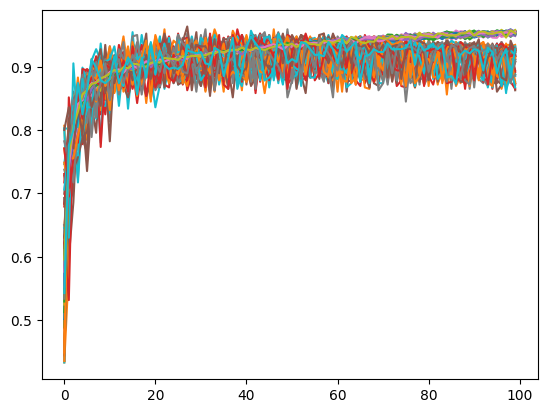

In [8]:
%matplotlib inline
acc_list = []
for i in tqdm(np.arange(50)):
    b_predictor = tf.keras.Sequential([
        layers.Flatten(),
        #layers.Dense(80, activation='relu'),
        #layers.Dense(20, activation='relu'),
        #layers.Dense(8, activation='relu'),
        #tf.keras.layers.Normalization(axis=-1),
        layers.Dense(8, activation='linear')
    ]) 
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    b_predictor.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = b_predictor.fit(X1_tr,
                          B_train_1,
                          epochs=100,
                          batch_size=100,
                          validation_data=(X1_tst, B_test_1),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    B1_tst_pred = b_predictor(X1_tst).numpy().argmax(axis=1)

    acc_list.append(accuracy_score(B1_tst_pred, B_test_1))

0.9123318385650225
0.020536207246709234


(array([ 3.,  4.,  0.,  3.,  2.,  0.,  5.,  8., 12., 13.]),
 array([0.8632287 , 0.87040359, 0.87757848, 0.88475336, 0.89192825,
        0.89910314, 0.90627803, 0.91345291, 0.9206278 , 0.92780269,
        0.93497758]),
 <BarContainer object of 10 artists>)

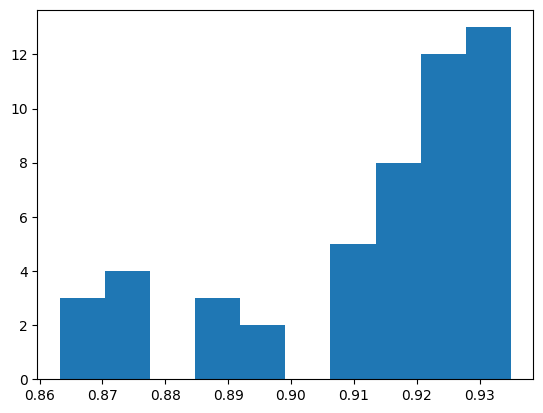

In [10]:
acc_list = np.array(acc_list)
np.savetxt('Saved evaluation metrics/acc_list_X',acc_list)
print(np.mean(acc_list, axis=0))
print(np.std(acc_list, axis=0))
plt.hist(acc_list)

#### Behaviour predictor: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [11]:
B_train_1_onehot = to_categorical(B_train_1, num_classes=8)

linear_reg = LinearRegression()
linear_reg.fit(X1_tr.reshape(X1_tr.shape[0],-1), B_train_1_onehot)

B1_tr_pred = linear_reg.predict(X1_tst.reshape(X1_tst.shape[0],-1)).argmax(axis=1)
B1_tst_pred = linear_reg.predict(X1_tst.reshape(X1_tst.shape[0],-1)).argmax(axis=1)

accuracy_score(B1_tst_pred, B_test_1)

0.07847533632286996

### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$
#### With neural net


----------------------------------

100%|███████████████████████████████████████████| 50/50 [01:28<00:00,  1.78s/it]


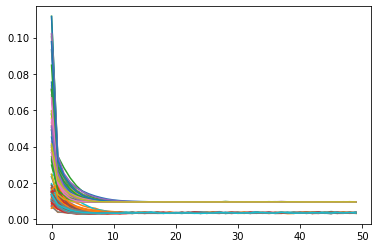

In [284]:
%matplotlib inline
mse_list = []
for i in tqdm(np.arange(50)):
    # Setting outliers to zero
    #Y_diff_tr[np.abs(Y_diff_tr) > Y_diff_tr.mean() + 3*Y_diff_tr.std()] = 0
    #Y_diff_tst[np.abs(Y_diff_tst) > Y_diff_tst.mean() + 3*Y_diff_tst.std()] = 0

    ### Scaling input and output data
    #Yinmax = (np.abs(Y0_tr)).max() # Parameters for scaling
    #Y0_tr, Y0_tst = Y0_tr/Yinmax, Y0_tst/Yinmax
    Ydmax = (np.abs(Ydiff_tr)).max() # Parameters for scaling
    Ydiff_tr, Ydiff_tst = Ydiff_tr/Ydmax, Ydiff_tst/Ydmax

    # Defining the model
    model_ydiff_f_xt = tf.keras.Sequential([
        layers.Flatten(),
        #layers.Dense(3, activation='relu'),
        #layers.Dense(5, activation='relu'),
        #layers.Dense(7, activation='relu'),
        #layers.Dense(10, activation='relu'),
        #layers.Dense(7, activation='relu'),
        #layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='linear')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model_ydiff_f_xt.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])

    history = model_ydiff_f_xt.fit(X0_tr,
                          Ydiff_tr,
                          epochs=50,
                          batch_size=100,
                          validation_data=(X0_tst, Ydiff_tst),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])

    # Preidctions
    Ydiff_tr_pred = model_ydiff_f_xt(X0_tr).numpy()
    Ydiff_tst_pred = model_ydiff_f_xt(X0_tst).numpy()

    # Inverse scaling the data
    Ydiff_tr_pred, Ydiff_tr = Ydiff_tr_pred*Ydmax, Ydiff_tr*Ydmax
    Ydiff_tst_pred, Ydiff_tst = Ydiff_tst_pred*Ydmax, Ydiff_tst*Ydmax,
    
    Y1_tr_pred = Y0_tr + Ydiff_tr_pred
    Y1_tst_pred = Y0_tst + Ydiff_tst_pred

    # Evaluation
    baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
    modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
    baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
    modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
    
    #print('On training set \n')
    #print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
    #print('\nOn test set \n')
    #print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))
    
    mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])

[0.00158655 0.00147812 0.0004299  0.00054532]
[6.50521303e-19 6.22449253e-06 3.25260652e-19 2.20045649e-05]


(array([ 2.,  0.,  1.,  3.,  4.,  7.,  7., 14.,  9.,  3.]),
 array([-0.42857959, -0.40388882, -0.37919805, -0.35450728, -0.32981651,
        -0.30512574, -0.28043497, -0.2557442 , -0.23105343, -0.20636266,
        -0.18167189]),
 <BarContainer object of 10 artists>)

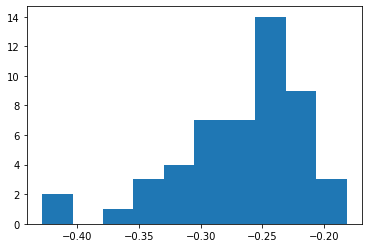

In [285]:
mse_list = np.array(mse_list)
np.savetxt('Saved evaluation metrics/mse_list_'+algorithm,mse_list)
print(np.mean(mse_list, axis=0))
print(np.std(mse_list, axis=0))
goodness_of_fit = 1 -  mse_list[:,3]/mse_list[:,2]
plt.hist(goodness_of_fit)

#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [288]:
linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)

Ydiff_tr_pred = linear_reg.predict(Y0_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tr_pred = Y0_tr + Ydiff_tr_pred
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

# Evaluation
baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))

1 - modelmse_tst/baseline_tst

On training set 

Baseline mse 0.00159 Model mse: 0.00147

On test set 

Baseline mse 0.00043 Model mse: 0.00054


-0.2637978828356071

### Hits at rank metric

In [264]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.7393418100224383